# Learning Curves of Lucie-7B

In [275]:
import slugify
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import colorcet as cc
import warnings

### 1. Load all benchmark results

Load CSV files ([evaluation_learning_curve_lucie.csv](evaluation_learning_curve_lucie.csv) and [evaluation_baselines.csv](evaluation_baselines.csv)).

In [276]:
# !pip install pandas matplotlib seaborn python-slugify
lucie_results = pd.read_csv(
    "../evaluation_learning_curve_lucie.csv"
)
baseline_results = pd.read_csv(
    "../evaluation_baselines.csv"
)

# Print some statistics
def unique(field): return len(lucie_results[field].unique())
print(f"✅ {unique('training_tokens')} Lucie checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")
def unique(field): return len(baseline_results[field].unique())
print(f"✅ {unique('model_name')} baseline checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")

✅ 43 Lucie checkpoints evaluated on 5 benchmarks (192 datasets)
✅ 9 baseline checkpoints evaluated on 5 benchmarks (184 datasets)


In [277]:
# Correction for the baselines !

baseline_results['training_phase'] = baseline_results['training_phase'].map({'main': '1_main', 'instruction': '4_instruct_full'})
def map_baseline_name_to_expe(model_name):
    if 'Croissant' in model_name:
        return 'CroissantLLM'
    if 'pythia' in model_name:
        return 'Pythia'
    if 'Mistral' in model_name:
        return 'Mistral'
    if 'Llama-3.1' in model_name:
        return 'Llama-3.1'
    if 'bloom' in model_name:
        return 'Bloom'
    if 'falcon' in model_name:
        return 'Falcon'
    else:
        return model_name

baseline_results['expe_name'] = baseline_results['model_name'].apply(map_baseline_name_to_expe)
baseline_results['model_name'] = 'Baseline'

In [278]:
results = pd.concat([lucie_results, baseline_results])

### 2. Setup a plot config (and some normalization of model/dataset names)

In the code cell below, `benchmarks` must be a dictionary:
* key: the name of the benchmark (will be plotted as a title)
* values: a list of dataset names that will be plotted together (see column `dataset` of [the CSV file](evaluation_learning_curve_lucie.csv))


In [279]:
# What to plot
BENCHMARKS = {
    "Leaderboard v1":
        [
            "arc_challenge",        "hellaswag",
            "mmlu",
            "mmlu_continuation",    "winogrande",
            "gsm8k",                "truthfulqa_mc2",
        ],
    "Leaderbooard":
        [
            "leaderboard_bbh", "leaderboard_gpqa", "leaderboard_math_hard", "leaderboard_musr"
        ],
    "French Bench":
        [
            "french_bench_arc_challenge",   "french_bench_hellaswag",
            "french_bench_grammar",         "french_bench_vocab",
        ],
    "French Bench Generative":
        [
            "french_bench_fquadv2_genq",   "french_bench_multifquad",
            "french_bench_orangesum_abstract",         "french_bench_trivia",
        ],
    "Multilingual ARC benchmark":
        [
            "arc_fr",   "arc_es",
            "arc_de",   "arc_it",
        ],
}

# Output folder to save figures
OUTPUT_FOLDER = "../figs"

In [280]:
def can_be_rounded(x, ratio):
    return abs(x / ratio) % 1 <= 0.05

def format_big_integer(x):
    if x <= 1000: return str(int(x))
    if x <= 950_000 and can_be_rounded(x, 1000): return f"{x / 1_000:.0f}K"
    if x <= 950_000_000 and can_be_rounded(x, 1_000_000): return f"{x / 1_000_000:.0f}M"
    if x <= 950_000_000_000 and can_be_rounded(x, 1_000_000_000): return f"{x / 1_000_000_000:.0f}B"
    if x <= 950_000_000_000: return f"{x / 1_000_000_000:.1f}B"
    if can_be_rounded(x, 1_000_000_000_000): return f"{x / 1_000_000_000_000:.0f}T"
    return f"{x / 1_000_000_000_000:.1f}T"


In [281]:
def is_valid(model_name, phase, expe, restrict_to):
    for restrict in restrict_to:
        r_model_name, r_phase, r_expe = restrict
        if (r_model_name is None or r_model_name == model_name) and \
           (r_phase is None or r_phase == phase) and \
           (r_expe is None or r_expe == expe):
            return True
    return False

def plot_results(lucie_results, title, benchmark_names, filename, restrict_to=None, bar_plot=False, xlogscale=True):
    lucie_results['allowed'] = lucie_results.apply(lambda row: is_valid(row['model_name'], row['training_phase'], row['expe_name'], restrict_to), axis=1)
    lucie_results = lucie_results[lucie_results['allowed']]

    ncols = min(2, len(benchmark_names))
    nrows = (len(benchmark_names) + 1) // ncols

    fig, ax = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))
    if title:
        plt.suptitle(title, fontsize=16, weight='bold', y=0.9)  # Reduce y value to bring the title closer

    # Plot parameters
    marker_types = {
        '1_main': 'o', 
        '2_extension': '*', 
        '3_annealing': 's', 
        '4_instruct_full': '^', 
        '4_instruct_full_deprecated': 'D', 
        '4_instruct_lora': 'v'
        }  

    # Ensure at least 50 different colors
    if len(lucie_results['expe_name'].unique()) > 20:
        warnings.warn("More than 20 experiments, using a larger color palette.")

    palette = sns.color_palette("tab20", n_colors=20)
    # colors = sns.color_palette("Spectral", num_colors)
    color_mapping = {expe: palette[i % 20] for i, expe in enumerate(lucie_results['expe_name'].unique())}
    xlabel = True
    norm_tokens = 1e09 if not xlogscale else 1

    # Score names and few shot
    benchmark2score = dict(zip(lucie_results['dataset'], lucie_results['score_name']))
    benchmark2fewshot = dict(zip(lucie_results['dataset'], lucie_results['num_fewshot']))

    # Select the benchmark
    for i_bench, benchmark_name in enumerate(benchmark_names):
        plt.subplot(nrows, ncols, i_bench+1)
        lucie_results_bench = lucie_results[lucie_results["dataset"] == benchmark_name].copy()

        title = f"{benchmark_name}\n"
        if benchmark_name in benchmark2score:
            score_name = benchmark2score[benchmark_name].replace(",none", "")
            title += f"({score_name}"
        if benchmark_name in benchmark2fewshot:
            num_fewshot = benchmark2fewshot[benchmark_name]
            if num_fewshot:
                try:
                    num_fewshot = int(num_fewshot)
                    title += f", {num_fewshot}-shot"
                except Exception:
                    num_fewshot = None
        title += ")"
        plt.title(title, weight='bold')

        # Loop on expe
        for (model_name, phase, expe), df in lucie_results_bench.groupby(['model_name', 'training_phase', 'expe_name']):
            df.sort_values('training_tokens', inplace=True)

            if phase not in marker_types:
                raise ValueError(f"Unknown phase: {phase}. Please define a marker for this phase.")
            marker = marker_types[phase]
            color = color_mapping.get(expe, 'black')  # Default color

            #### PLOT IS HERE ####
            if bar_plot:
                if len(df) > 1:
                    df = df.iloc[-1]
                plt.bar(f"({phase}, {expe})", df['score'],  yerr=df['stderr'], label=f"{model_name} ({phase}, {expe})", color=color)
                
            else:
                if len(df) > 1 and phase == "1_main":
                    plt.plot(df['training_tokens'], df['score'], label=f"({phase}, {expe})", color=color, linewidth=1)
                    plt.plot(df.iloc[-1]['training_tokens'], df.iloc[-1]['score'], marker, label=f"{model_name} ({phase}, {expe})", color=color, linewidth=1)
                elif len(df) > 1:
                    raise ValueError(f"Unexpected number of rows for {phase} {expe} in {benchmark_name}: {len(df)}")
                else:
                    plt.plot(df['training_tokens'], df['score'], marker, label=f"{model_name} ({phase}, {expe})", color=color)

        if xlogscale:
            plt.xscale('log')  # Set x-axis to log scale
            xticks_coordinates, _ = plt.xticks()
            previous = xticks_coordinates[0]
            new_xticks = [previous]
            for x in xticks_coordinates[1:]:
                if x / previous >= 10 - 1e-06:
                    new_xticks.append(3 * previous)
                new_xticks.append(x)
                previous = x
            if norm_tokens == 1:
                new_xticks_labels = [format_big_integer(x) for x in new_xticks]
                plt.xticks(new_xticks, new_xticks_labels)
            else:
                plt.xticks(new_xticks)

        if bar_plot:
            plt.xticks([])
            plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # You can adjust grid style (line type, transparency)
            
        else:
            plt.grid(True, linestyle='--', alpha=0.7)  # You can adjust grid style (line type, transparency)
            m, M = 100*1e9, 20*1e12
            plt.xlim(m, M)
            if xlabel:
                plt.xlabel("# training tokens" + (" (in billions)" if norm_tokens == 1e09 else (" (log scale)" if xlogscale else "")))

    # Adjust layout to add space for legend
    fig.subplots_adjust(bottom=0.2)

    # Set a single legend after the plots
    ax = plt.subplot(nrows, ncols, 1)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=10, ncol=3)  # Legend after plots

    fig.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the plot to fit in the figure
    if filename:
        print(f"Saving {filename}...")
        plt.savefig(filename, facecolor='w', bbox_inches='tight')
    plt.show()


Saving ../figs/v2-learning-curve-evaluation-leaderboard-v1.png...


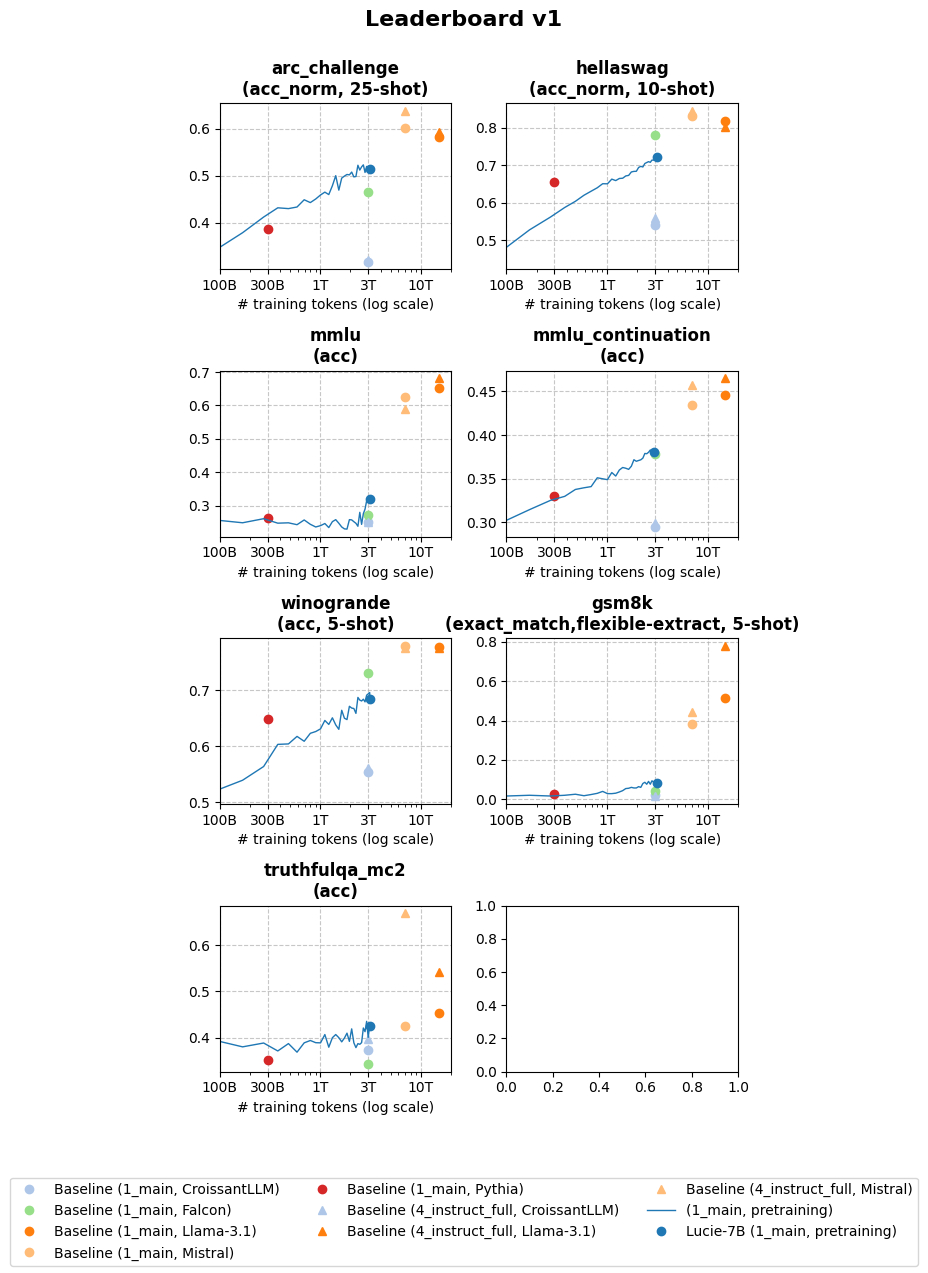

Saving ../figs/v2-learning-curve-evaluation-leaderbooard.png...


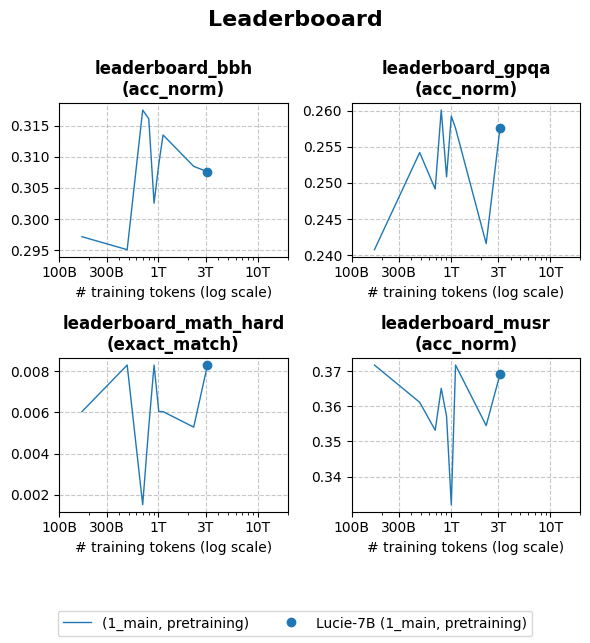

Saving ../figs/v2-learning-curve-evaluation-french-bench.png...


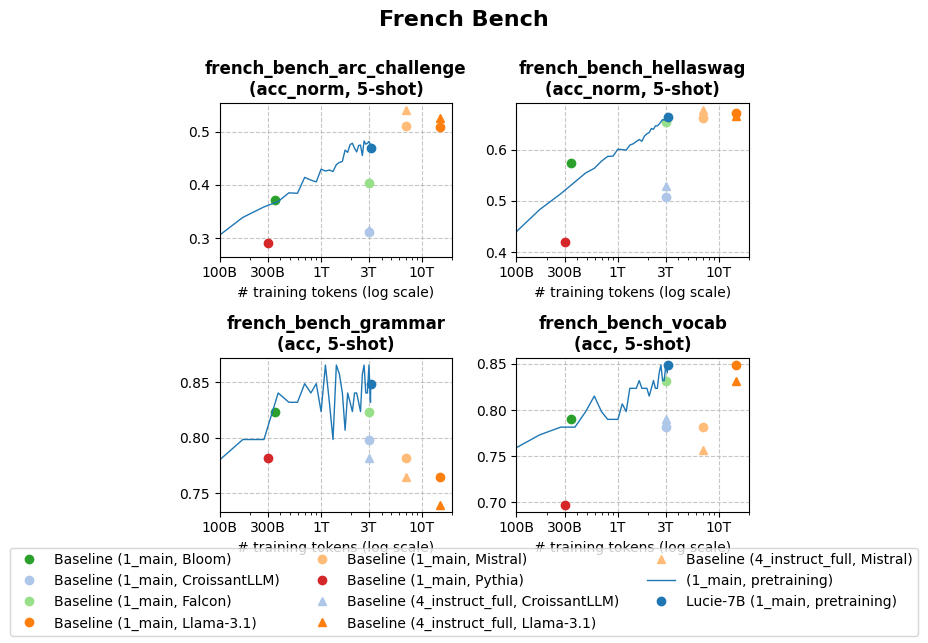

Saving ../figs/v2-learning-curve-evaluation-french-bench-generative.png...


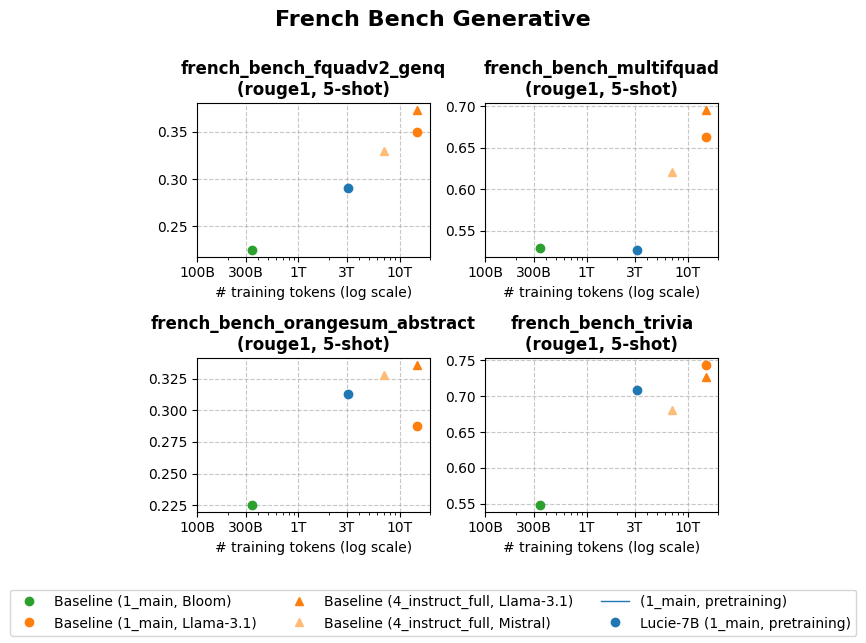

Saving ../figs/v2-learning-curve-evaluation-multilingual-arc-benchmark.png...


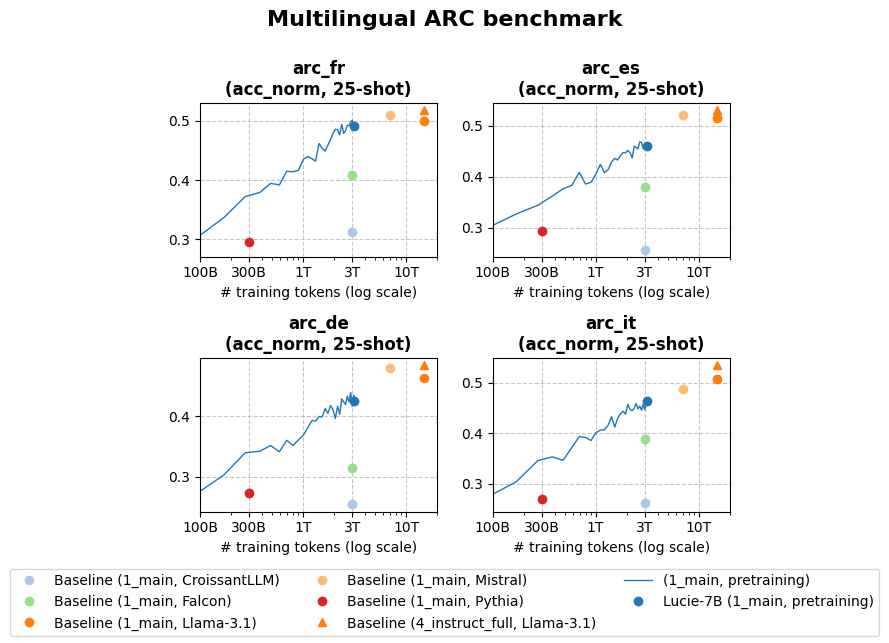

In [282]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Baseline', None, None),
    # ('1_main', '_'),
    # ('2_extension', 'rope_20M'),
    # ('3_annealing', '5B_tokens-mix6'),
    # ('4_instruct_full', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        filename = os.path.join(OUTPUT_FOLDER, slugify.slugify(f"v2_learning_curve_evaluation_{title}") + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to)


Saving ../figs/v2-bar-instruction-leaderboard-v1.png...


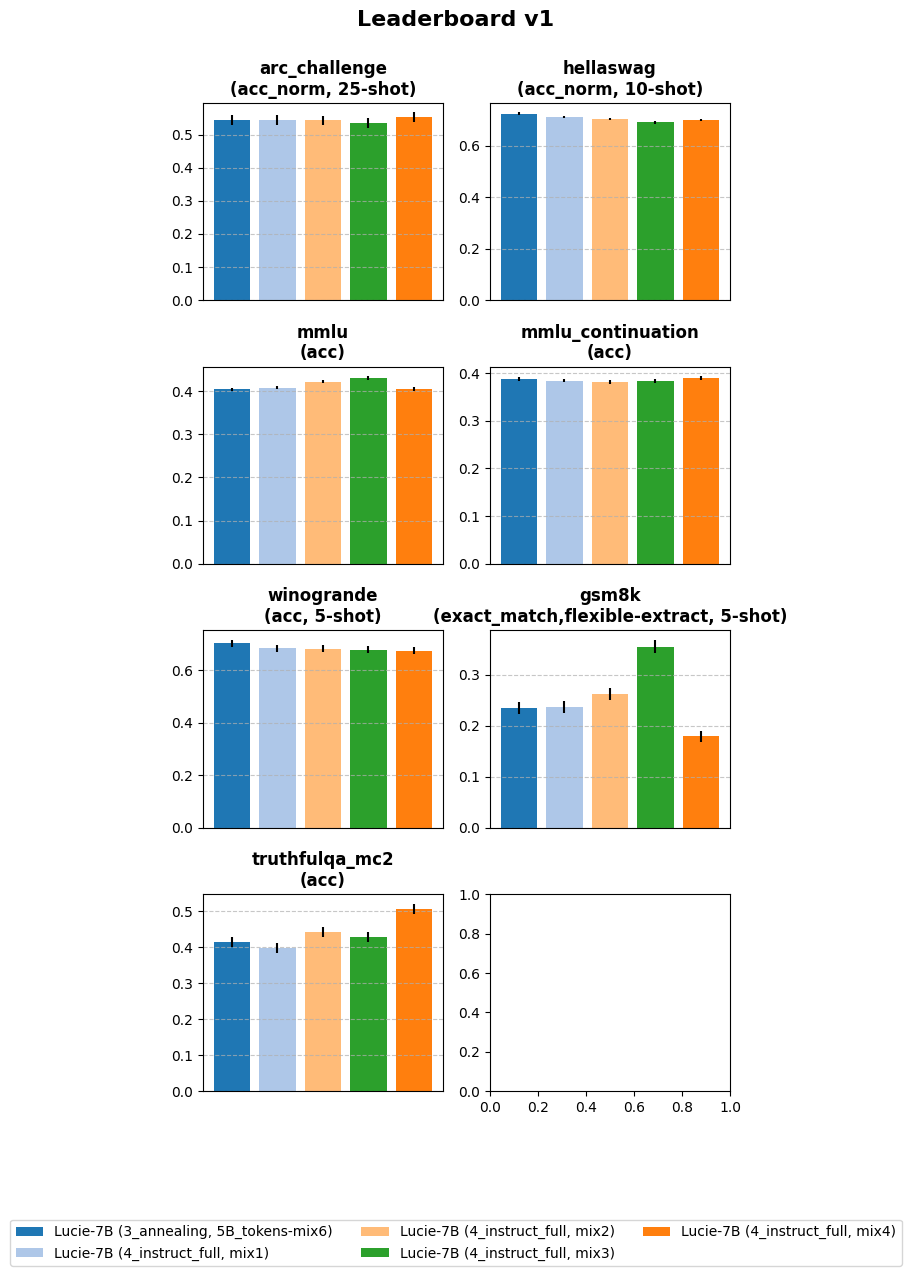

Saving ../figs/v2-bar-instruction-leaderbooard.png...


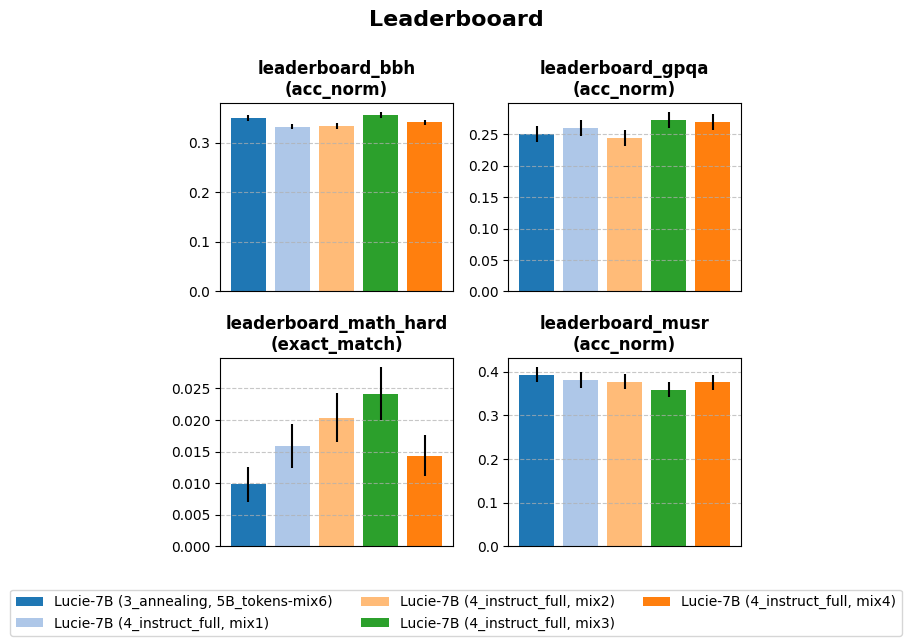

Saving ../figs/v2-bar-instruction-french-bench.png...


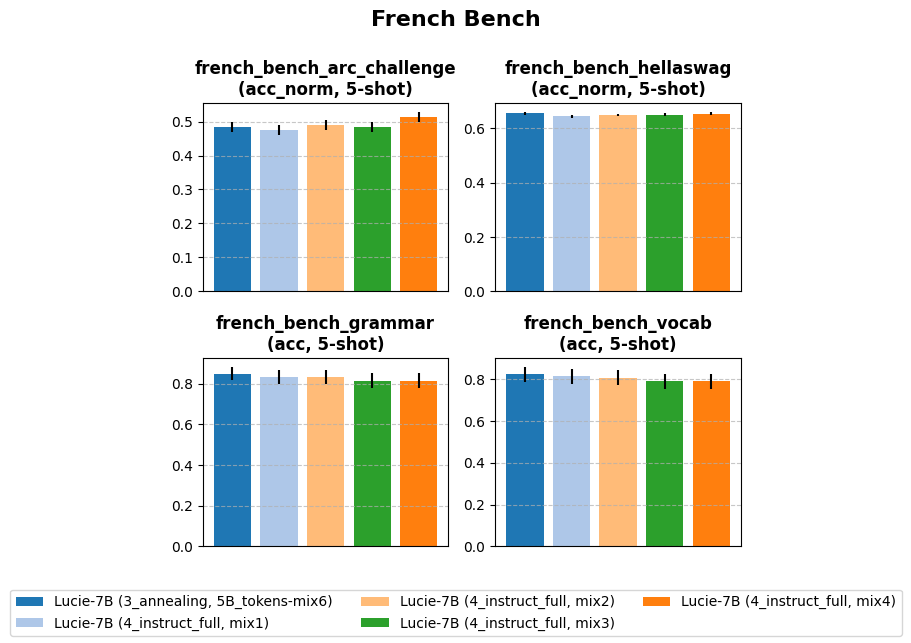

Saving ../figs/v2-bar-instruction-french-bench-generative.png...


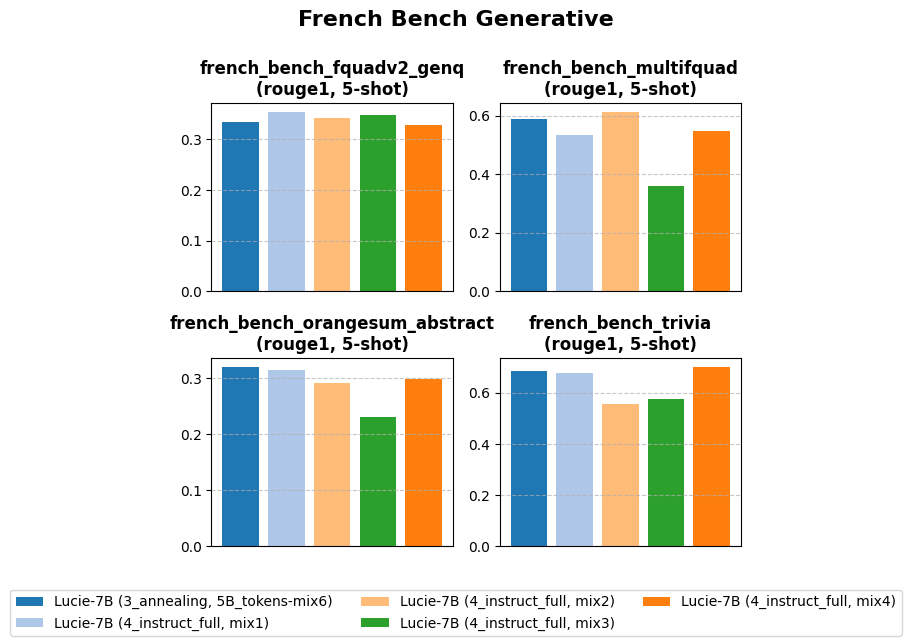

Saving ../figs/v2-bar-instruction-multilingual-arc-benchmark.png...


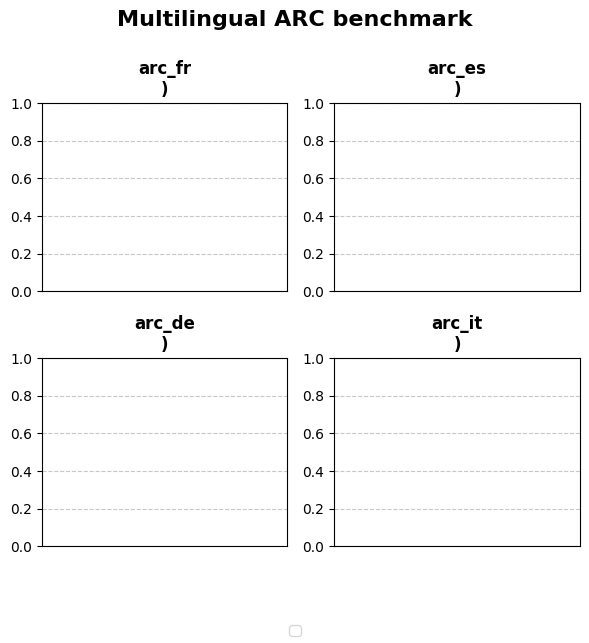

In [283]:
restrict_to = [
    # ('1_main', '_'),
    # ('2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Lucie-7B', '4_instruct_full', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        filename = os.path.join(OUTPUT_FOLDER, slugify.slugify(f"v2_bar_instruction_{title}") + ".png")

    plot_results(lucie_results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)
